# This is the script for all machine learning algorithms on tabular dataset

In [46]:
import os
import pandas as pd
import numpy as np
import itertools 
import tqdm
import random
import json
from time import sleep
import matplotlib.pyplot as plt


# Algorithm package
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb

# Utilities
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, cross_val_score
# from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
import warnings 
warnings.filterwarnings("ignore")

# Data Loading

In [3]:
df_raw = pd.read_json("Data/PreparedData.json", lines=True)

# Label Preparing

## Recovery

In [4]:
df = df_raw[df_raw["RecoveryDesc"] == df_raw["RecoveryDesc"]]
df = df[(df["RecoveryDesc"].isin(["At recovery", "Not at recovery"]))]
df.reset_index().drop("index", axis=1)
print(df.shape)

labelList = []
for idx, row in df.iterrows():
    if (row["ReliableChangeDesc"] == "Reliable improvement") & (row["ReliableRecoveryDesc"] == "Reliable recovery") & (row["RecoveryDesc"] == "At recovery"):
        labelList.append(1)
    else:
        labelList.append(0)
df["label"] = labelList
labelList = ["label"]

(391, 285)


In [5]:
# prepare the feature list
colnames = []
for item in df.columns:
    if item.startswith("Item"):
        colnames.append(item)

# Model Performance Demonstration

In [6]:
def SingleModelPlot(resultList, modelName):
    df = pd.DataFrame(resultList)
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
    values = df.values
    columns = df.columns.tolist()
    axs.violinplot(values,
                  showmeans=False,
                  showmedians=True)
    axs.set_title('Violin plot')

    axs.yaxis.grid(True)
    axs.set_xticks([y + 1 for y in range(len(columns))],
                  labels=columns)
    axs.set_xlabel(modelName)
    axs.set_ylabel('Observed values')

    print("Model: {}\nAccuracy mean: {:.4f}, Precision mean: {:.4f}, Recall Mean: {:.4f}, F1 Mean: {:.4f}".format(
                                                                                                                    modelName,
                                                                                                                    np.mean(df["Accuracy"]), 
                                                                                                                    np.mean(df["Precision"]),
                                                                                                                    np.mean(df["Recall"]),
                                                                                                                    np.mean(df["F1"]),
                                                                                                                )
         )

In [7]:
# mannually generate the search grid
def makeGrid(pars_dict):  
    keys=pars_dict.keys()
    combinations=itertools.product(*pars_dict.values())
    ds=[dict(zip(keys,cc)) for cc in combinations]
    return ds

In [8]:
def MyGridSearch(model, param_dict, df, colnames, labelList):
    searchSpace = makeGrid(param_dict)
    print("Search Space Size:" + len(searchSpace).__str__())
    resultList = []
    for param in tqdm.tqdm(searchSpace):
        #sleep(1)
        clf = model(**param)
        # scores = cross_val_score(clf, X, y, cv=5, scoring="accuracy", n_jobs=5)
        f1List = []
        skf = StratifiedKFold(n_splits=5)
        for i, (train_index, val_index) in enumerate(skf.split(df[colnames], df[labelList])):
            (X_train, Y_train) = df.iloc[train_index][colnames], df.iloc[train_index][labelList]
            (X_val, Y_val) = df.iloc[val_index][colnames], df.iloc[val_index][labelList]
            clf.fit(X_train, Y_train)
            predicted_val = clf.predict(X_val)
            predicted_val = (predicted_val > 0.5)
            f1 = f1_score(Y_val[labelList], predicted_val)
            f1List.append(f1)
        
        result = {}
        result["f1_mean"] = np.mean(f1List)
        result["f1_std"] = np.std(f1List)
        result["f1"] = f1List
        result["param"] = param
        resultList.append(result)
    sortedResult = sorted(resultList, key=lambda x: x["f1_mean"], reverse=True)
    print(sortedResult[:5])
    return sortedResult

## DT

In [9]:
param_dict = {
    "criterion": ["gini","entropy","log_loss"],
    "max_depth": [None,2,8,16],
    "min_samples_split": [2,4,16,64],
    "min_samples_leaf": [1,4,16,64],
    "min_weight_fraction_leaf": [0.0, 0.2, 0.4, 0.5],
    "max_features": [None, 20, 40, 80],
    "max_leaf_nodes": [None, 20, 40, 80],   
}

In [10]:
searchResult = MyGridSearch(tree.DecisionTreeClassifier, param_dict, df, colnames, labelList)

Search Space Size:12288


100%|██████████| 12288/12288 [06:04<00:00, 33.68it/s]

[{'f1_mean': 0.552322338447237, 'f1_std': 0.051056297771492155, 'f1': [0.5494505494505495, 0.5135135135135135, 0.4810126582278481, 0.6037735849056604, 0.6138613861386139], 'param': {'criterion': 'log_loss', 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'max_features': None, 'max_leaf_nodes': None}}, {'f1_mean': 0.5520766488413547, 'f1_std': 0.0937931751596763, 'f1': [0.6, 0.375, 0.6363636363636364, 0.6078431372549019, 0.5411764705882353], 'param': {'criterion': 'entropy', 'max_depth': 16, 'min_samples_split': 16, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.0, 'max_features': None, 'max_leaf_nodes': 80}}, {'f1_mean': 0.5519445466813888, 'f1_std': 0.0664918459484082, 'f1': [0.6060606060606061, 0.4473684210526316, 0.5, 0.6153846153846154, 0.5909090909090909], 'param': {'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 64, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.0, 'max_features': None, 'max_leaf_nodes': 40}

In [11]:
DTAccList = []
for i in range(100):
    # Keep 10% data as the test data
    train, test = train_test_split(df, test_size=0.1)
    train.shape

    param = searchResult[0]["param"]
    clf_dt = tree.DecisionTreeClassifier(**param)
    clf_dt = clf_dt.fit(train[colnames],train[labelList])

    predicted_test_tfidf = clf_dt.predict(test[colnames])

    accuracy_score, precision_score, recall_score, f1_score
    result = {}
    result["Accuracy"] = accuracy_score(test[labelList], (predicted_test_tfidf>0.5))
    result["Precision"] = precision_score(test[labelList], (predicted_test_tfidf>0.5))
    result["Recall"] = recall_score(test[labelList], (predicted_test_tfidf>0.5))
    result["F1"] = f1_score(test[labelList], (predicted_test_tfidf>0.5))

    DTAccList.append(result)

print(DTAccList)

[{'Accuracy': 0.525, 'Precision': 0.45, 'Recall': 0.5294117647058824, 'F1': 0.4864864864864865}, {'Accuracy': 0.525, 'Precision': 0.4117647058823529, 'Recall': 0.4375, 'F1': 0.42424242424242425}, {'Accuracy': 0.6, 'Precision': 0.4666666666666667, 'Recall': 0.4666666666666667, 'F1': 0.4666666666666667}, {'Accuracy': 0.475, 'Precision': 0.4, 'Recall': 0.3333333333333333, 'F1': 0.36363636363636365}, {'Accuracy': 0.525, 'Precision': 0.42105263157894735, 'Recall': 0.5, 'F1': 0.45714285714285713}, {'Accuracy': 0.55, 'Precision': 0.47368421052631576, 'Recall': 0.5294117647058824, 'F1': 0.5}, {'Accuracy': 0.525, 'Precision': 0.5, 'Recall': 0.2631578947368421, 'F1': 0.3448275862068966}, {'Accuracy': 0.525, 'Precision': 0.4090909090909091, 'Recall': 0.6, 'F1': 0.4864864864864865}, {'Accuracy': 0.6, 'Precision': 0.5652173913043478, 'Recall': 0.6842105263157895, 'F1': 0.6190476190476191}, {'Accuracy': 0.5, 'Precision': 0.3125, 'Recall': 0.35714285714285715, 'F1': 0.3333333333333333}, {'Accuracy': 

Model: Decision Tree
Accuracy mean: 0.5175, Precision mean: 0.4539, Recall Mean: 0.4568, F1 Mean: 0.4392


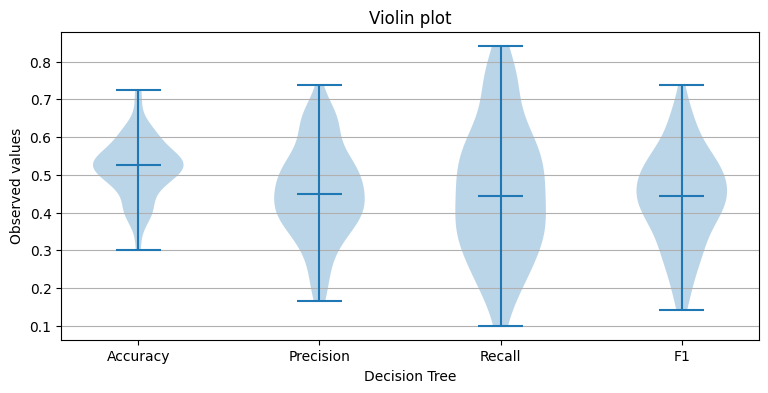

In [12]:
SingleModelPlot(DTAccList, "Decision Tree")

## Random Forest

In [13]:
param_dict = {
    "n_estimators": [50, 100, 150],
    "criterion": ["gini","entropy"],
    "max_depth": [None, 8, 16],
    "max_features": [None, "sqrt", 20, 80],
    "max_leaf_nodes": [None, 20, 40, 80],
    "max_samples": [None, 0.5, 0.7, 1.0],
    "random_state": [random.randint(0, 32767)],
    "n_jobs": [-1],
}

In [14]:
searchResult = MyGridSearch(RandomForestClassifier, param_dict, df, colnames, labelList)

Search Space Size:1152


100%|██████████| 1152/1152 [11:31<00:00,  1.67it/s]

[{'f1_mean': 0.4318569410806107, 'f1_std': 0.12014058674786471, 'f1': [0.34615384615384615, 0.2641509433962264, 0.5964912280701754, 0.5294117647058824, 0.4230769230769231], 'param': {'n_estimators': 50, 'criterion': 'gini', 'max_depth': 16, 'max_features': 'sqrt', 'max_leaf_nodes': 40, 'max_samples': 0.5, 'random_state': 9648, 'n_jobs': -1}}, {'f1_mean': 0.427878977006766, 'f1_std': 0.12010262597387829, 'f1': [0.34615384615384615, 0.2545454545454545, 0.5862068965517241, 0.5294117647058824, 0.4230769230769231], 'param': {'n_estimators': 50, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': 40, 'max_samples': 0.5, 'random_state': 9648, 'n_jobs': -1}}, {'f1_mean': 0.420200374705609, 'f1_std': 0.11382387030809973, 'f1': [0.27450980392156865, 0.3389830508474576, 0.4126984126984127, 0.6060606060606061, 0.46875], 'param': {'n_estimators': 50, 'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'max_leaf_nodes': 80, 'max_samples': None, 'random_state': 96

In [15]:
RFAccList = []
for i in range(100):
    # Keep 10% data as the test data
    train, test = train_test_split(df, test_size=0.1)
    train.shape
    
    param = searchResult[0]["param"]
    clf_rf = RandomForestClassifier(**param)
    clf_rf = clf_rf.fit(train[colnames],train[labelList])

    predicted_test_tfidf = clf_rf.predict(test[colnames])
    result = {}
    result["Accuracy"] = accuracy_score(test[labelList], (predicted_test_tfidf>0.5))
    result["Precision"] = precision_score(test[labelList], (predicted_test_tfidf>0.5))
    result["Recall"] = recall_score(test[labelList], (predicted_test_tfidf>0.5))
    result["F1"] = f1_score(test[labelList], (predicted_test_tfidf>0.5))

    RFAccList.append(result)

print(RFAccList)

[{'Accuracy': 0.55, 'Precision': 0.2, 'Recall': 0.06666666666666667, 'F1': 0.1}, {'Accuracy': 0.525, 'Precision': 0.25, 'Recall': 0.23076923076923078, 'F1': 0.24}, {'Accuracy': 0.55, 'Precision': 0.36363636363636365, 'Recall': 0.26666666666666666, 'F1': 0.3076923076923077}, {'Accuracy': 0.525, 'Precision': 0.2857142857142857, 'Recall': 0.125, 'F1': 0.17391304347826086}, {'Accuracy': 0.5, 'Precision': 0.5, 'Recall': 0.25, 'F1': 0.3333333333333333}, {'Accuracy': 0.525, 'Precision': 0.4444444444444444, 'Recall': 0.2222222222222222, 'F1': 0.2962962962962963}, {'Accuracy': 0.625, 'Precision': 0.5, 'Recall': 0.4666666666666667, 'F1': 0.4827586206896552}, {'Accuracy': 0.6, 'Precision': 0.4444444444444444, 'Recall': 0.26666666666666666, 'F1': 0.3333333333333333}, {'Accuracy': 0.45, 'Precision': 0.2222222222222222, 'Recall': 0.11764705882352941, 'F1': 0.15384615384615385}, {'Accuracy': 0.6, 'Precision': 0.5, 'Recall': 0.375, 'F1': 0.42857142857142855}, {'Accuracy': 0.625, 'Precision': 0.5, 'Rec

Model: Random Forest
Accuracy mean: 0.5600, Precision mean: 0.4686, Recall Mean: 0.2523, F1 Mean: 0.3154


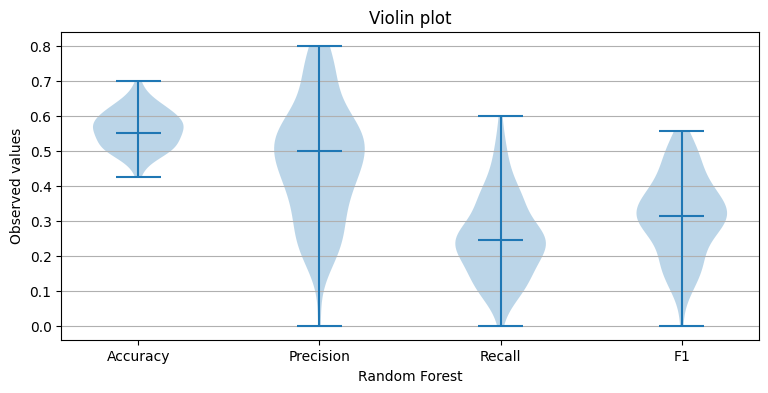

In [16]:
SingleModelPlot(RFAccList, "Random Forest")

# GBM

In [17]:
param_dict = {
    "n_estimators": [10, 50, 100, 150],
    "max_depth": [-1, 8, 16],
    "min_child_samples": [10, 20, 40],
    "num_leaves": [15, 31, 63, 90, 120],
    "colsample_bytree": [0.5, 0.7, 1.0],
    "subsample": [0.5, 0.7, 1.0],
    "random_state": [random.randint(0, 32767)],
    "n_jobs": [-1],
    "verbose": [-1]
}

In [18]:
searchResult = MyGridSearch(LGBMClassifier, param_dict, df, colnames, labelList)

Search Space Size:1620


100%|██████████| 1620/1620 [12:47<00:00,  2.11it/s]

[{'f1_mean': 0.44240437158469953, 'f1_std': 0.041017253947371234, 'f1': [0.39344262295081966, 0.39344262295081966, 0.4666666666666667, 0.4918032786885246, 0.4666666666666667], 'param': {'n_estimators': 100, 'max_depth': 8, 'min_child_samples': 10, 'num_leaves': 15, 'colsample_bytree': 1.0, 'subsample': 0.5, 'random_state': 15847, 'n_jobs': -1, 'verbose': -1}}, {'f1_mean': 0.44240437158469953, 'f1_std': 0.041017253947371234, 'f1': [0.39344262295081966, 0.39344262295081966, 0.4666666666666667, 0.4918032786885246, 0.4666666666666667], 'param': {'n_estimators': 100, 'max_depth': 8, 'min_child_samples': 10, 'num_leaves': 15, 'colsample_bytree': 1.0, 'subsample': 0.7, 'random_state': 15847, 'n_jobs': -1, 'verbose': -1}}, {'f1_mean': 0.44240437158469953, 'f1_std': 0.041017253947371234, 'f1': [0.39344262295081966, 0.39344262295081966, 0.4666666666666667, 0.4918032786885246, 0.4666666666666667], 'param': {'n_estimators': 100, 'max_depth': 8, 'min_child_samples': 10, 'num_leaves': 15, 'colsample

In [19]:
GBMAccList = []
for i in range(100):
    # Keep 10% data as the test data
    train, test = train_test_split(df, test_size=0.1)
    train.shape

    param = searchResult[0]["param"]
    clf_gbm = LGBMClassifier(**param)
    clf_gbm = clf_gbm.fit(train[colnames],train[labelList])

    predicted_test_tfidf = clf_gbm.predict(test[colnames])
    result = {}
    result["Accuracy"] = accuracy_score(test[labelList], (predicted_test_tfidf>0.5))
    result["Precision"] = precision_score(test[labelList], (predicted_test_tfidf>0.5))
    result["Recall"] = recall_score(test[labelList], (predicted_test_tfidf>0.5))
    result["F1"] = f1_score(test[labelList], (predicted_test_tfidf>0.5))

    GBMAccList.append(result)

print(GBMAccList)

[{'Accuracy': 0.425, 'Precision': 0.4166666666666667, 'Recall': 0.23809523809523808, 'F1': 0.30303030303030304}, {'Accuracy': 0.5, 'Precision': 0.4, 'Recall': 0.35294117647058826, 'F1': 0.375}, {'Accuracy': 0.575, 'Precision': 0.4117647058823529, 'Recall': 0.5, 'F1': 0.45161290322580644}, {'Accuracy': 0.575, 'Precision': 0.5263157894736842, 'Recall': 0.5555555555555556, 'F1': 0.5405405405405406}, {'Accuracy': 0.625, 'Precision': 0.7, 'Recall': 0.3684210526315789, 'F1': 0.4827586206896552}, {'Accuracy': 0.55, 'Precision': 0.5454545454545454, 'Recall': 0.3157894736842105, 'F1': 0.4}, {'Accuracy': 0.5, 'Precision': 0.4, 'Recall': 0.2222222222222222, 'F1': 0.2857142857142857}, {'Accuracy': 0.625, 'Precision': 0.6428571428571429, 'Recall': 0.47368421052631576, 'F1': 0.5454545454545454}, {'Accuracy': 0.625, 'Precision': 0.5714285714285714, 'Recall': 0.47058823529411764, 'F1': 0.5161290322580645}, {'Accuracy': 0.6, 'Precision': 0.5, 'Recall': 0.3125, 'F1': 0.38461538461538464}, {'Accuracy': 0

Model: GBM
Accuracy mean: 0.5753, Precision mean: 0.5004, Recall Mean: 0.3730, F1 Mean: 0.4197


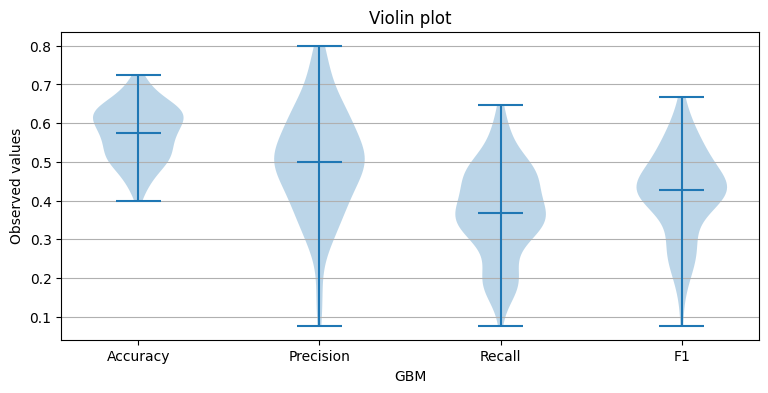

In [20]:
SingleModelPlot(GBMAccList, "GBM")

## XGboost

In [21]:
param_dict = {
    "n_estimators": [10, 50, 100, 150],
    "max_depth": [4,8,10,16],
    "objective": ["binary:logistic"],
    "n_jobs": [5],
    "subsample": [0.5, 1.0],
    'colsample_bytree': [0.3, 0.5, 0.7, 1.0],
    'colsample_bylevel': [0.3, 0.5, 0.7, 1.0],
    'colsample_bynode': [0.3, 0.5, 0.7, 1.0], 
    'num_parallel_tree': [4, 8, 16],
}

In [22]:
searchResult = MyGridSearch(xgb.XGBRegressor, param_dict, df, colnames, labelList)

Search Space Size:6144


100%|██████████| 6144/6144 [2:09:20<00:00,  1.26s/it]  

[{'f1_mean': 0.46202221742881794, 'f1_std': 0.051618214727045475, 'f1': [0.4262295081967213, 0.38596491228070173, 0.53125, 0.5, 0.4666666666666667], 'param': {'n_estimators': 150, 'max_depth': 16, 'objective': 'binary:logistic', 'n_jobs': 5, 'subsample': 1.0, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'colsample_bynode': 1.0, 'num_parallel_tree': 4}}, {'f1_mean': 0.4611564101313409, 'f1_std': 0.07338564322813641, 'f1': [0.36363636363636365, 0.4067796610169492, 0.5625, 0.5245901639344263, 0.4482758620689655], 'param': {'n_estimators': 100, 'max_depth': 4, 'objective': 'binary:logistic', 'n_jobs': 5, 'subsample': 0.5, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'num_parallel_tree': 4}}, {'f1_mean': 0.4592271589132063, 'f1_std': 0.09025357460590973, 'f1': [0.43333333333333335, 0.2962962962962963, 0.4918032786885246, 0.5483870967741935, 0.5263157894736842], 'param': {'n_estimators': 50, 'max_depth': 4, 'objective': 'binary:logistic', 'n_jobs': 5, 'su

In [23]:
XGBAccList = []
for i in range(100):
    # Keep 10% data as the test data
    train, test = train_test_split(df, test_size=0.1)
    train.shape

    param = searchResult[0]["param"]
    # clf_xgb = xgb.XGBRegressor(**param_dict)
    # clf_xgb  = xgb.XGBRegressor(objective="binary:logistic", random_state=42)
    clf_xgb = xgb.XGBRegressor(**param)
    clf_xgb.fit(train[colnames], train[labelList])

    predicted_test_tfidf = clf_xgb.predict(test[colnames])
    result = {}
    result["Accuracy"] = accuracy_score(test[labelList], (predicted_test_tfidf>0.5))
    result["Precision"] = precision_score(test[labelList], (predicted_test_tfidf>0.5))
    result["Recall"] = recall_score(test[labelList], (predicted_test_tfidf>0.5))
    result["F1"] = f1_score(test[labelList], (predicted_test_tfidf>0.5))

    XGBAccList.append(result)

print(XGBAccList)

[{'Accuracy': 0.525, 'Precision': 0.375, 'Recall': 0.17647058823529413, 'F1': 0.24}, {'Accuracy': 0.575, 'Precision': 0.5333333333333333, 'Recall': 0.4444444444444444, 'F1': 0.48484848484848486}, {'Accuracy': 0.425, 'Precision': 0.5, 'Recall': 0.2608695652173913, 'F1': 0.34285714285714286}, {'Accuracy': 0.55, 'Precision': 0.4, 'Recall': 0.25, 'F1': 0.3076923076923077}, {'Accuracy': 0.525, 'Precision': 0.6666666666666666, 'Recall': 0.4166666666666667, 'F1': 0.5128205128205128}, {'Accuracy': 0.625, 'Precision': 0.6153846153846154, 'Recall': 0.4444444444444444, 'F1': 0.5161290322580645}, {'Accuracy': 0.4, 'Precision': 0.4, 'Recall': 0.2857142857142857, 'F1': 0.3333333333333333}, {'Accuracy': 0.5, 'Precision': 0.42857142857142855, 'Recall': 0.3333333333333333, 'F1': 0.375}, {'Accuracy': 0.55, 'Precision': 0.6666666666666666, 'Recall': 0.36363636363636365, 'F1': 0.47058823529411764}, {'Accuracy': 0.625, 'Precision': 0.7692307692307693, 'Recall': 0.45454545454545453, 'F1': 0.5714285714285714

Model: XGBoost
Accuracy mean: 0.5517, Precision mean: 0.4906, Recall Mean: 0.3724, F1 Mean: 0.4132


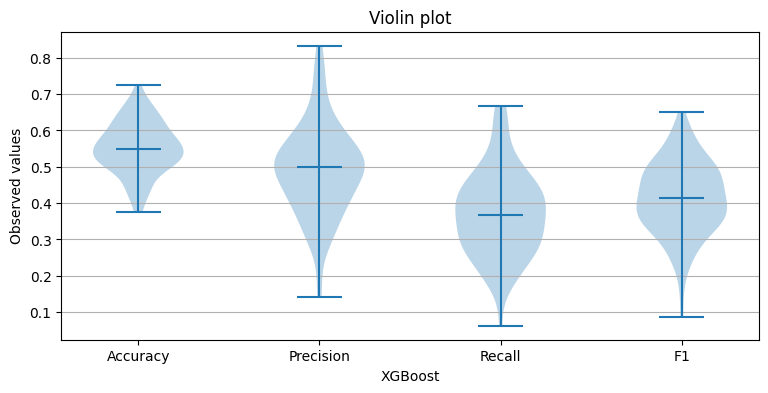

In [24]:
SingleModelPlot(XGBAccList, "XGBoost")

## Comparison

In [47]:
with open("Tabular-ML-Recovery.json", "w") as writer:
    writer.write(json.dumps(allResult, ensure_ascii=False))

In [30]:
def PreAll(allResult):
    modelList = list(allResult.keys())
    accResult = {}
    preResult = {}
    recResult = {}
    f1Result = {}
    for model in modelList:
        accResult[model] = [x["Accuracy"] for x in allResult[model]]
        preResult[model] = [x["Precision"] for x in allResult[model]]
        recResult[model] = [x["Recall"] for x in allResult[model]]
        f1Result[model] = [x["F1"] for x in allResult[model]]
    return accResult, preResult, recResult, f1Result

In [25]:
allResult = {}
allResult["Decision Tree"] = DTAccList
allResult["Random Forest"] = RFAccList
allResult["Light GBM"] = GBMAccList
allResult["XGBoost"] = XGBAccList

In [31]:
accResult, preResult, recResult, f1Result = PreAll(allResult)

In [32]:
accResult

{'Decision Tree': [0.525,
  0.525,
  0.6,
  0.475,
  0.525,
  0.55,
  0.525,
  0.525,
  0.6,
  0.5,
  0.525,
  0.55,
  0.4,
  0.6,
  0.6,
  0.475,
  0.525,
  0.4,
  0.55,
  0.55,
  0.6,
  0.625,
  0.4,
  0.3,
  0.4,
  0.425,
  0.45,
  0.55,
  0.5,
  0.5,
  0.675,
  0.375,
  0.5,
  0.55,
  0.6,
  0.725,
  0.625,
  0.525,
  0.525,
  0.55,
  0.425,
  0.6,
  0.525,
  0.4,
  0.575,
  0.35,
  0.55,
  0.625,
  0.475,
  0.375,
  0.3,
  0.5,
  0.7,
  0.55,
  0.525,
  0.5,
  0.475,
  0.525,
  0.6,
  0.55,
  0.525,
  0.575,
  0.55,
  0.45,
  0.525,
  0.525,
  0.525,
  0.55,
  0.5,
  0.475,
  0.625,
  0.525,
  0.4,
  0.4,
  0.475,
  0.4,
  0.5,
  0.575,
  0.525,
  0.5,
  0.575,
  0.475,
  0.5,
  0.525,
  0.45,
  0.625,
  0.475,
  0.55,
  0.425,
  0.5,
  0.55,
  0.425,
  0.625,
  0.475,
  0.725,
  0.5,
  0.55,
  0.5,
  0.55,
  0.575],
 'Random Forest': [0.55,
  0.525,
  0.55,
  0.525,
  0.5,
  0.525,
  0.625,
  0.6,
  0.45,
  0.6,
  0.625,
  0.45,
  0.5,
  0.525,
  0.5,
  0.525,
  0.575,
  0.575,
 

In [34]:
modelList = list(accResult.keys())
valueList = [accResult[model] for model in modelList]

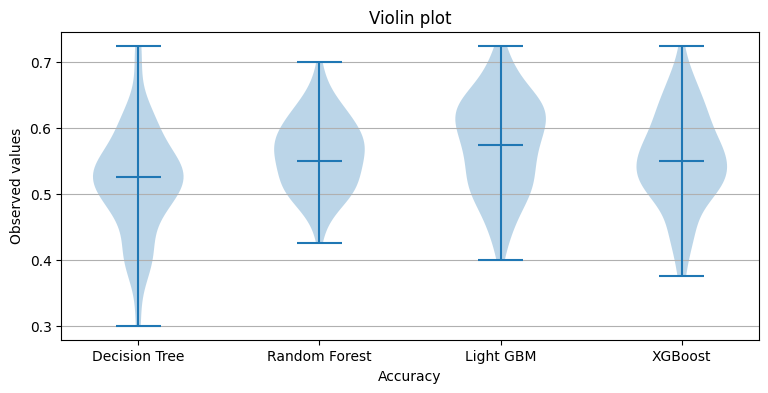

In [39]:
# Accuracy plot
modelList = list(accResult.keys())
valueList = [accResult[model] for model in modelList]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
axs.violinplot(valueList,
              showmeans=False,
              showmedians=True)
axs.set_title('Violin plot')

axs.yaxis.grid(True)
axs.set_xticks([y + 1 for y in range(len(modelList))],
              labels=modelList)
axs.set_xlabel("Accuracy")
axs.set_ylabel('Observed values')

plt.show()

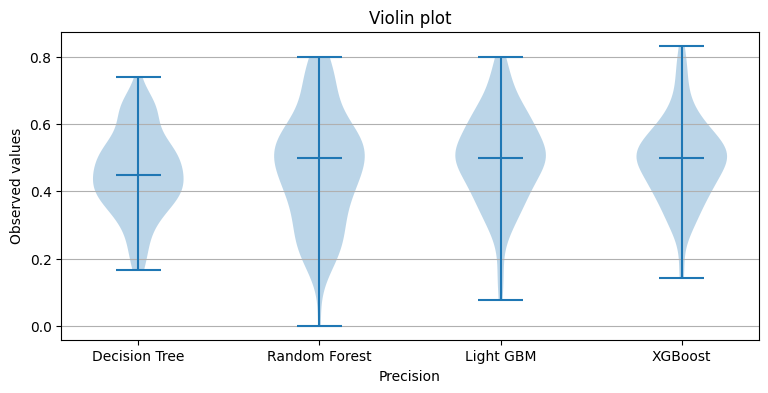

In [41]:
# Precision plot
# modelList = list(accResult.keys())
valueList = [preResult[model] for model in modelList]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
axs.violinplot(valueList,
              showmeans=False,
              showmedians=True)
axs.set_title('Violin plot')

axs.yaxis.grid(True)
axs.set_xticks([y + 1 for y in range(len(modelList))],
              labels=modelList)
axs.set_xlabel("Precision")
axs.set_ylabel('Observed values')

plt.show()

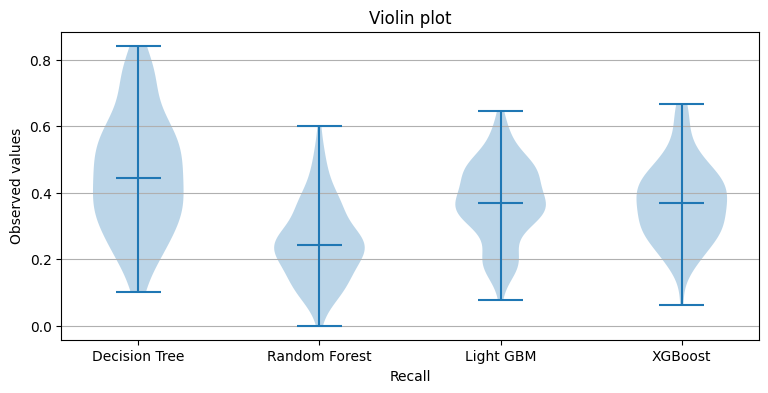

In [42]:
# Precision plot
# modelList = list(accResult.keys())
valueList = [recResult[model] for model in modelList]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
axs.violinplot(valueList,
              showmeans=False,
              showmedians=True)
axs.set_title('Violin plot')

axs.yaxis.grid(True)
axs.set_xticks([y + 1 for y in range(len(modelList))],
              labels=modelList)
axs.set_xlabel("Recall")
axs.set_ylabel('Observed values')

plt.show()

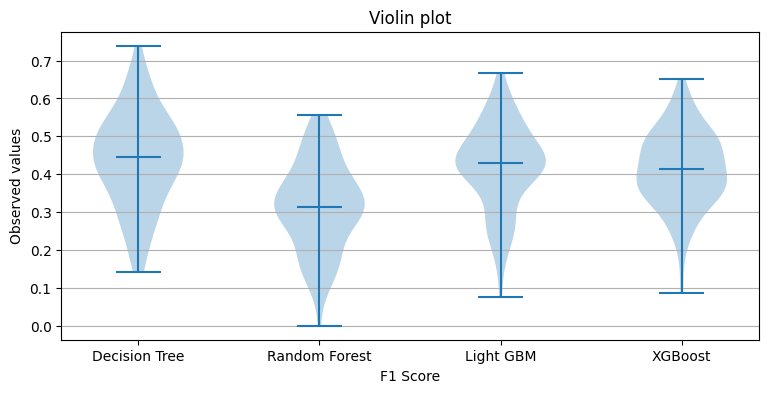

In [44]:
# F1 plot
# modelList = list(accResult.keys())
valueList = [f1Result[model] for model in modelList]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
axs.violinplot(valueList,
              showmeans=False,
              showmedians=True)
axs.set_title('Violin plot')

axs.yaxis.grid(True)
axs.set_xticks([y + 1 for y in range(len(modelList))],
              labels=modelList)
axs.set_xlabel("F1 Score")
axs.set_ylabel('Observed values')

plt.show()